Does the model even work??? I need to try with a simpler dataset. I suspect this may just be an inappropriate problem for this model, the shiny palette is effectively random. Although you would expect it to eventually overfit - somehow identifying which pokemon and then remembering that colour palette.

Notes:
- Model gets stuck and stops improving.
- Noise could be a problem, PatchGan has a sigmoid so predicts [0,1]. Label noise is <code>+= 0.05 * tf.random.normal(tf.shape(y_real))</code> so cfan be outside the possible range of the discriminator. Instead try label smoothing.
- Try a pretrained encoder and do not update the weights
- Improve sketches to be closer to a human drawing.
- Further data augmentations?
- LAMBDA=100 was used for images of size 224(?) is that still correct for 128 images? Should we expect that a 70x70 patch's loss be less than the loss of a 224x224 image? In which case, we may need to change LAMBDA when we change the output image size.
- increase model to full size for 224 (will need to resize imaghes to 256)

# Imports and Settings

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import os
import datetime
import pandas as pd
import numpy as np
import functools
import cv2
import albumentations as A
from IPython.display import display
import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import plot_model

PATH = pathlib.Path.cwd()
DATA_DIR = PATH.parent / 'data'
IMAGES_DIR = DATA_DIR / 'raw' / 'data-224'
SKETCH_DIR = DATA_DIR / 'interim' / 'DexiNed-fuse'
MODELS_DIR = PATH.parent / 'models'

RUN_NAME = datetime.datetime.now().strftime("%Y-%m-%d %H%M")
print(RUN_NAME)

USE_WANDB = False
IS_TEST = False

2021-09-14 2022


In [5]:
# has a tendency to run out of gpu space
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# # mixed precision training - complicated with GANS
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

In [23]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# model / training hyperparameters
LAMBDA = 100
EPOCHS = 2
PATCH_SIZE = 8
# label smoothing
REAL_LABEL_LOWER = 0.95
REAL_LABEL_UPPER = 1.05

# dataset parameters
# Typically, the batch size (n_batch) is set to 1.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
IMAGE_SIZE = [128, 128]

# dataset sizes
IMAGE_COUNT = len(list(SKETCH_DIR.glob('*.png')))
VAL_PROPORTION = 0.1
VALID_LENGTH = int(IMAGE_COUNT * VAL_PROPORTION)
TRAIN_LENGTH = IMAGE_COUNT - VALID_LENGTH

# number of batches
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE

# settings for testing for fast iteration
TEST_SIZE = None
TEST_SETTINGS = {}

if IS_TEST:
    # need to sort this line out
    # TEST_SIZE = 97 # TRAIN_LENGTH // BATCH_SIZE (8)
    TEST_SETTINGS = {'subset':True}
    EPOCHS = 2
    STEPS_PER_EPOCH = TRAIN_LENGTH // TEST_SIZE // BATCH_SIZE
    VALIDATION_STEPS = VALID_LENGTH // TEST_SIZE // BATCH_SIZE

In [7]:
if USE_WANDB:
    os.environ['WANDB_NOTEBOOK_NAME'] = "3. sketch2frog.ipynb"
    wandb.login()

    # Step1: Initialize W&B run
    wandb.init(
        project='sketch2frog',
        name=RUN_NAME,
        save_code=True)

In [8]:
if USE_WANDB:
    # log model config to wandb
    wandb.config.update({
        "RUN_NAME": RUN_NAME,
        "IMAGE_COUNT": IMAGE_COUNT,
        "VAL_PROPORTION": VAL_PROPORTION,
        "TRAIN_LENGTH": TRAIN_LENGTH,
        "VALID_LENGTH": VALID_LENGTH,
        "STEPS_PER_EPOCH": STEPS_PER_EPOCH,
        "VALIDATION_STEPS": VALIDATION_STEPS,
        "SEED": SEED,
        "REAL_LABEL_LOWER": REAL_LABEL_LOWER,
        "REAL_LABEL_UPPER": REAL_LABEL_UPPER,
        "BATCH_SIZE": BATCH_SIZE,
        "BUFFER_SIZE": BUFFER_SIZE,
        "IMAGE_SIZE": IMAGE_SIZE,
        "LAMBDA": LAMBDA,
        "EPOCHS": EPOCHS,
        "IS_TEST": IS_TEST,
        "TEST_SETTINGS": TEST_SETTINGS,
        "TEST_SIZE": TEST_SIZE,
        "PATCH_SIZE": PATCH_SIZE,
        "g_optimizer": "Adam",
        "g_learning_rate": 0.0002,
        "g_beta_1": 0.5,
        "d_optimizer": "Adam",
        "d_learning_rate": 0.0002,
        "d_beta_1": 0.5,
    })

In [9]:
# wandb.finish()

# Prepare Dataset

In [10]:
def get_target_path(sketch_path):
    """Given a path to a shiny png, find the corresponding normal png"""
    image_path = tf.strings.regex_replace(sketch_path, "\\\\interim\\\\DexiNed-fuse", '\\\\raw\\\\data-224')
    return image_path

def decode_sketch(sketch_path, image_shape):
    # takes a png file path and returns a tensor
    sketch = tf.io.read_file(sketch_path)
    sketch = tf.io.decode_png(sketch)
    sketch = tf.cast(sketch, tf.float32) / 255
    return tf.image.resize(sketch, image_shape, method='nearest')

def decode_image(image_path, image_shape):
    # takes a png file path and returns a tensor
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3) / 255 # [0,255] -> [0,1]
    img = img*2 - 1 # [0,1] -> [-1,1]  (range of tanh)
    img = tf.cast(img, tf.float32)
    return tf.image.resize(img, image_shape, method='nearest')

def process_path(sketch_path, image_shape=[128,128]):
    # takes the sketch image path and returns tensors for the sketch and source image
    image_path = get_target_path(sketch_path)
    sketch = decode_sketch(sketch_path, image_shape)
    image = decode_image(image_path, image_shape)
    return sketch, image

def configure_for_performance(ds, subset=False):
    ds = ds.cache()
    if subset: # use 10% of the data
        ds = ds.shard(TEST_SIZE, 0)
    ds = ds.shuffle(buffer_size=BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def aug_fn(sketch, image):
    # both images should be transformed the same
    data = {"image":sketch, 'image1':image}
    aug_data = transforms(**data)
    aug_sketch = aug_data["image"]
    aug_image = aug_data["image1"]
    return aug_sketch, aug_image

def data_augmentation(sketch, image):
    # wrapper around augmentation function for tensorflow compatibility
    aug_sketch, aug_image = tf.numpy_function(func=aug_fn, inp=[sketch, image], Tout=[tf.float32, tf.float32])
    return aug_sketch, aug_image

# Instantiate augmentations - jitter, rotate, mirror
transforms = A.Compose([
    A.PadIfNeeded(min_height=IMAGE_SIZE[0]+20, min_width=IMAGE_SIZE[1]+20, border_mode=cv2.BORDER_CONSTANT, value=[1,1,1]),
    A.Rotate(limit=40, border_mode=cv2.BORDER_CONSTANT, value=[1,1,1]),
    A.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    A.HorizontalFlip()
    ], additional_targets={'image1':'image'})

# get a list of all the sketche paths
list_ds = tf.data.Dataset.list_files(str(SKETCH_DIR/'*.png'), shuffle=False)
list_ds = list_ds.shuffle(IMAGE_COUNT, reshuffle_each_iteration=False)

# train / valid split
train_ds = list_ds.skip(VALID_LENGTH)
valid_ds = list_ds.take(VALID_LENGTH)
  
# process filepaths to images
train_ds = train_ds.map(functools.partial(process_path, image_shape=IMAGE_SIZE), num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(functools.partial(process_path, image_shape=IMAGE_SIZE), num_parallel_calls=AUTOTUNE)

# data augmentation on train set
train_ds = train_ds.map(data_augmentation)

# cache, shuffle, batch, repeat, prefetch
train_ds = configure_for_performance(train_ds, **TEST_SETTINGS)
valid_ds = configure_for_performance(valid_ds, **TEST_SETTINGS)

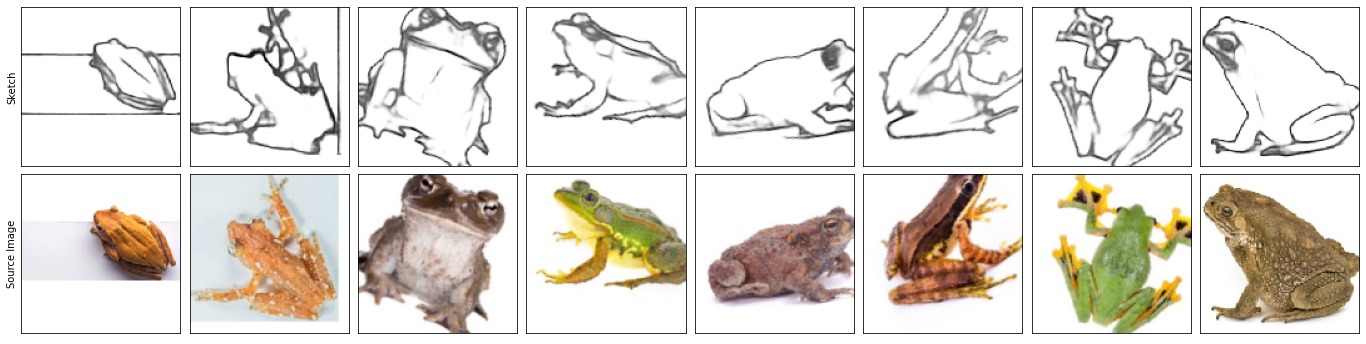

In [11]:
def show_batch(size=3, max_examples=8):
    """Print a batch of sketches and target frogs,
    for large batch sizes limit number to print"""
    
    # get a batch and prep the figure
    for sketch_batch, image_batch in train_ds.take(1):
        # determine how many images to plot
        to_plot = min(sketch_batch.shape[0], max_examples)
        fig, axs = plt.subplots(2, to_plot, figsize=(size*to_plot, size*2))
        
        # print each img in the batch
        for i, (sketch, image) in enumerate(zip(sketch_batch, image_batch)):
            axs[0,i].imshow(sketch.numpy().squeeze(), cmap='gray')
            axs[1,i].imshow((image.numpy().squeeze()+1)/2)
            if i == to_plot-1:
                break

    # remove axis ticks
    for ax in matplotlib.cbook.flatten(axs):
        ax.set(xticks=[], yticks=[])

    # set titles
    axs[0,0].set_ylabel('Sketch')
    axs[1,0].set_ylabel('Source Image')

    # adjust styling and show
    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()
    plt.close()
    
show_batch()

# Build model
Dataset is 80x80 but we resize to 128x128

## UNET Generator model

In [12]:
# UNET (generator)
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)

    # add downsampling layer
    # if using batchnorm, then no bias needed
    g = layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=not(batchnorm))(layer_in)

    # optional batchnorm
    if batchnorm:
        # always operate in training mode, even when used during inference
        g = layers.BatchNormalization()(g, training=True)

    # All ReLUs in the encoder are leaky, with slope 0.2
    g = layers.LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)

    # add upsampling layer
    g = layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)

    # add batch norm always
    g = layers.BatchNormalization()(g, training=True)
    # optional dropout
    if dropout:
        g = layers.Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = layers.Concatenate()([g, skip_in])
    # ReLUs in the decoder are not leaky
    g = layers.ReLU()(g)
    return g

def define_generator(sketch_shape=(128,128,1)):
    """Modified structure for 128x128 input, simply removed one layer from each side"""
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)
    # image input
    in_image = layers.Input(shape=sketch_shape) # (batch_size, 128, 128, 1)

    # encoder model: C64-C128-C256-C512-C512-C512-C512
    # BatchNorm is not applied to the first C64 layer in the encoder
    e1 = encoder_block(in_image, 64, batchnorm=False) # (batch_size, 64, 64, 64)
    e2 = encoder_block(e1, 128)  # (batch_size, 32, 32, 128)
    e3 = encoder_block(e2, 256)  # (batch_size, 16, 16, 256)
    e4 = encoder_block(e3, 512)  # (batch_size,  8,  8, 512)
    e5 = encoder_block(e4, 512)  # (batch_size,  4,  4, 512)
    e6 = encoder_block(e5, 512)  # (batch_size,  2,  2, 512)

    # bottleneck, no batch norm, relu not leaky
    b = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e6)
    b = layers.ReLU()(b) # (batch_size, 1, 1, 512)

    # decoder model: CD512-CD1024-CD1024-C1024-C512-C256-C128
    # N.B. only first 3 use dropout
    d1 = decoder_block(b,  e6, 512, dropout=True)   # (batch_size,   2,   2, 1024) # doubles filters due to concat
    d2 = decoder_block(d1, e5, 512, dropout=True)   # (batch_size,   4,   4, 1024)
    d3 = decoder_block(d2, e4, 512, dropout=True)   # (batch_size,   8,   8, 1024)
    d4 = decoder_block(d3, e3, 256, dropout=False)  # (batch_size,  16,  16,  512)
    d5 = decoder_block(d4, e2, 128, dropout=False)  # (batch_size,  32,  32,  256)
    d6 = decoder_block(d5, e1,  64, dropout=False)  # (batch_size,  64,  64,  128)

    # output (batch_size, 128, 128, 3)
    g = layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d6)
    out_image = tf.keras.layers.Activation('tanh')(g)

    return Model(in_image, out_image)

# create the model
# model = define_generator()
# summarize the model
# model.summary()
# # plot the model
# plot_model(model, show_shapes=True, show_layer_names=True)

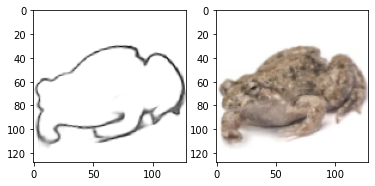

In [13]:
# grab a sample image and mask to use throughout training
for sketch, image in train_ds.take(1):
  sample_sketch, sample_image = sketch[0], image[0]

fig, axs = plt.subplots(1,2) 
axs[0].imshow(sample_sketch, cmap='gray')
axs[1].imshow((sample_image+1)/2)
plt.show()

The training=True is intentional here since you want the batch statistics, while running the model on the test dataset. If you use training=False, you get the accumulated statistics learned from the training dataset (which you don't want).

## PatchGAN Discriminator model

In [14]:
# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

def print_receptive_fields():
    # output layer 1x1 pixel with a 4x4 kernel and 1x1 stride
    rf = receptive_field(1, 4, 1)
    print(rf)

    # second last layer with 4x4 kernel and 1x1 stride
    rf = receptive_field(rf, 4, 1)
    print(rf)

    # 3 PatchGAN layers with 4x4 kernel and 2x2 stride
    rf = receptive_field(rf, 4, 2)
    print(rf)
    rf = receptive_field(rf, 4, 2)
    print(rf)
    rf = receptive_field(rf, 4, 2)
    print(rf)
    
# print_receptive_fields()

Running the example prints the size of the receptive field for each layer in the model from the output layer to the input layer.<br>
We can see that each 1×1 pixel in the output layer maps to a 70×70 receptive field in the input layer.

In [15]:
# PatchGAN (discriminator)
def define_discriminator(sketch_shape=(128,128,1), image_shape=(128,128,3)):
    # weight initialization
    init = tf.initializers.RandomNormal(stddev=0.02)
    # source image input
    in_src_image = layers.Input(shape=sketch_shape) # (batch_size, 128, 128, 1)
    # target image input
    in_target_image = layers.Input(shape=image_shape) # (batch_size, 128, 128, 3)
    # concatenate images channel-wise (batch_size, 128, 128, 1+3=4)
    merged = layers.Concatenate()([in_src_image, in_target_image])

    # Ck denote a Convolution-BatchNorm-ReLU layer with k filters
    # model: C64-C128-C256-C512
    # C64 - BatchNorm is not applied to the first C64 layer (batch_size, 64, 64, 64)
    d = layers.Conv2D(64,  (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = layers.LeakyReLU(alpha=0.2)(d) # All ReLUs are leaky, with slope 0.2
    # C128 (batch_size, 32, 32, 128)
    d = layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # C256 (batch_size, 16, 16, 256)
    d = layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # C512 (batch_size, 8, 8, 512)
    d = layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # second last output layer - NB no strides (batch_size, 8, 8, 512)
    d = layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = layers.BatchNormalization()(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    # patch output (batch_size, 8, 8, 1)
    d = layers.Conv2D(1,   (4,4), padding='same', kernel_initializer=init)(d)
    # no activation if we want to use label smoothing
    # patch_out = layers.Activation('sigmoid')(d)
    patch_out = d

    # define model 
    return Model([in_src_image, in_target_image], patch_out)

# create the model
# test_disc = define_discriminator()
# # summarize the model
# model.summary()
# # plot the model
# plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

We can see that the model output will be an activation map with the size 8x8 pixels or activations and a single channel, with each value in the map corresponding to a 70×70 pixel patch of the input 128x128 image.

## Combined GAN Model

In [16]:
def pix2pix_generator_loss(y_pred, y_target, out_img, target_img, LAMBDA=100):
    """
    loss=['binary_crossentropy', 'mae']
    loss_weights=[1, 100]
    The Pix2Pix generator uses a composite of Adversarial Loss (BCE) and L1 Loss (Pixel Distance Loss)

    The adversarial loss influences whether the generator
    model can output images that are plausible in the target domain.
    This is calculated from the output of the discriminator.
    Non-saturating GAN Loss:
        maximize the probability of images being predicted as real.
    Hence y_target is an array of ones.
    
    The L1 loss regularizes the generator model to output images
    that are a plausible translation of the source image.
    This is calculated from the output of the generator.
    """   
    # binary cross entropy - patches
    gan_loss = generator_loss_object(y_target, y_pred)

    # Pixel distance loss (L1)
    l1_loss = tf.reduce_mean(tf.abs(target_img - out_img))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def pix2pix_discriminator_loss(d_real_pred, d_real_target, d_fake_pred, d_fake_target):
    """Combine the discriminator losses from both the real and fake images"""
    
    real_loss = discriminator_loss_object(d_real_target, d_real_pred)
    fake_loss = discriminator_loss_object(d_fake_target, d_fake_pred)
    
    return real_loss + fake_loss

In [17]:
class Pix2Pix(tf.keras.Model):
    """
    Inspired by this twitter post from the creator of keras
    https://twitter.com/fchollet/status/1250622989541838848/photo/1
    and the pix2pix tensorflow tutorial
    https://www.tensorflow.org/tutorials/generative/pix2pix

    patch_size is the size of the output of the PatchGAN discriminator
    """
    def __init__(self, generator, discriminator, patch_size=8, real_label_lower=0.8, real_label_upper=1.2):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.patch_size = patch_size
        self.real_label_lower = real_label_lower
        self.real_label_upper = real_label_upper
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn):
        super(Pix2Pix, self).compile()
        self.g_optimizer = g_optimizer # Adam(lr=0.0002, beta_1=0.5)
        self.d_optimizer = d_optimizer # Adam(lr=0.0002, beta_1=0.5)
        self.g_loss_fn = g_loss_fn # loss=['binary_crossentropy', 'mae'], loss_weights=[1, 100]
        self.d_loss_fn = d_loss_fn # bce, loss_weights=[0.5]

    def call(self, data, training=False):
        # unpack data into normal (A) / shiny (B)
        # X_realA, X_realB = data
        gen_out = self.generator(data, training=training)
        dis_out = self.discriminator([data, gen_out], training=training)

        return dis_out, gen_out

    def show_predictions(self, input_img, target_img=False, wandb_title=False, show_plot=False):
        dis_out, gen_out = self.call(input_img)
        
        if isinstance(target_img, tf.Tensor):
            titles = ['Input Sketch', 'Target Image', 'Predicted Image', 'PatchGAN Output']
            display_list = [input_img, target_img, gen_out, dis_out]
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        else:
            titles = ['Input Sketch', 'Predicted Image', 'PatchGAN Output']
            display_list = [input_img, gen_out, dis_out]
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        for i, (ax, title, img) in enumerate(zip(axs, titles, display_list)):
            
            if title == 'Input Sketch':
                img = img[0,...]
                img = tf.keras.preprocessing.image.array_to_img(img)
                ax.imshow(img, cmap='gray')
            elif title != 'PatchGAN Output':
                img = img[0,...]
                img = (img+1)/2
                img = tf.keras.preprocessing.image.array_to_img(img)
                ax.imshow(img)
            else:
                img = img[0,:,:,0].numpy()
                # img = -np.log(1 / img - 1) # undo sigmoid
                im = ax.imshow(img, vmin=0, vmax=1)
            
            # formatting
            ax.set_title(title)
            ax.axis('off')

        cb = fig.colorbar(im, ax=axs[-1], extend='both')
        plt.subplots_adjust(wspace=0.05, hspace=0.05)

        if wandb_title:
            wandb.log({wandb_title: plt})

        if show_plot:
            plt.show()
        plt.close()

    def train_step(self, data):
        """Chollet's approach trains the discriminator, then generates new images and trains the generator
        Each time overwriting the GradientTape and predictions.
        
        Meanwhile this approach (pix2pix tf tutorial) creates a gen_tape and disc_tape simultaneously.
        Thus the gradients for training the gen and disc must both be available at the same time.
        I suspect that this approach will require more VRAM,
        but since it only has a single forward pass through the generator it may save time overall"""
        
        # unpack data into sketches (input) and images (target)
        input_batch, target_batch = data
        batch_size = tf.shape(input_batch)[0]
        
        # create patchgan labels
        labels_real = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        labels_fake = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
        
        # create smoothed patchgan -labels for reals
        labels_real_smoothed = tf.random.uniform(
            shape=(batch_size, self.patch_size, self.patch_size, 1),
            minval=self.real_label_lower,
            maxval=self.real_label_upper)
        
        # complete the forward pass and calculate the losses
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # generate fake images once
            gen_output = self.generator(input_batch, training=True)
            
            # predict on reals and fakes separately due to Batchnorm layers
            disc_real_pred = self.discriminator([input_batch, target_batch], training=True)
            disc_fake_pred = self.discriminator([input_batch, gen_output], training=True)
            
            # y_target is an array of ones to maximise the probability of generated images
            # being predicted as real - non-saturating GAN loss
            gen_total_loss, gen_gan_loss, gen_l1_loss = self.g_loss_fn(
                y_pred=disc_fake_pred, y_target=labels_real,
                out_img=gen_output,  target_img=target_batch)
            
            # calculate the discriminator loss, combining reals and fakes
            # with one-sided label smoothing on the reals.
            disc_loss = self.d_loss_fn(
                d_real_pred=disc_real_pred, d_real_target=labels_real_smoothed,
                d_fake_pred=disc_fake_pred, d_fake_target=labels_fake)
        
        # calculate gradients and update weights
        gen_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_weights)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_weights))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_weights))

        return {
            'd_loss': disc_loss,
            'gen_total_loss': gen_total_loss,
            'gen_gan_loss': gen_gan_loss,
            'gen_l1_loss': gen_l1_loss
            }

First run used a label smoothing on both sides in both the discriminator and generator. Smoothing was a gaussian (mean=0, std=1) * 0.05. Doing so meant that the positive class could have target value above or below 1, not just above. There is also the possiblity of being very far from 1 or 0. By comparison, Chollet uses a uniform distribution*0.05 so target labels are [0, 0.05] [1, 1.05] only in the discriminator.

Now we will use: uniform smoothing on just the positive label (one sided) in the discriminator

https://datascience.stackexchange.com/questions/28764/one-sided-label-smoothing-in-gans

One sided Label Smoothing would smooth the positive target only. Only when training the Discriminator. When training the Generator we do not smooth the labels. This is because label smoothing is a form of regularisation to slow down the discriminator.

Should I use the same X_realA data fir training the discriminato and the generator? Or do I need to use half a batch on each? Chollet's example uses a different inpuit to G wehn training G and D. The tensorflow tutorial only generates images once.

<code>
generator
tanh - True
from_logits = True

Discriminator
sigmoid - off
from_logits=True
Required for label smoothing
</code>

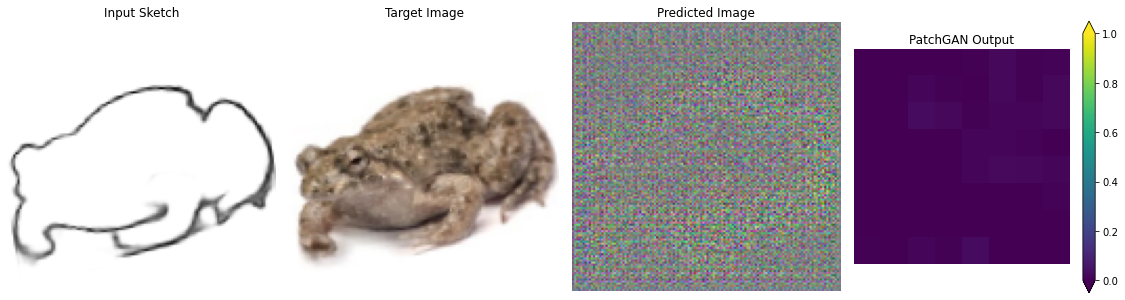

In [27]:
generator = define_generator()
discriminator = define_discriminator()
model = Pix2Pix(generator, discriminator,
                patch_size=PATCH_SIZE,
                real_label_lower=REAL_LABEL_LOWER,
                real_label_upper=REAL_LABEL_UPPER)

# generator loss has tanh activation [-1,1]
generator_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_loss = functools.partial(pix2pix_generator_loss, LAMBDA=LAMBDA)

# discriminator loss has no activation
discriminator_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator_loss = pix2pix_discriminator_loss

model.compile(
    tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), # g_optimizer
    tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), # d_optimizer
    generator_loss, discriminator_loss)

# check outputs
model.show_predictions(sample_sketch[tf.newaxis, ...], sample_image[tf.newaxis, ...], show_plot=True)

In [19]:
# observe improvement while training
class DisplayCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, steps_per_epoch, continue_training=False):
        """
        During the first epoch we want to log more frequently.
        If we continue training from the nth epoch we don't want 
        these extra logs on epoch n.
        
        During the first epoch, logs are madfe evenly on a logarithmic scale."""
        
        self.is_first_epoch = not(continue_training)
        self.batches_to_log = np.geomspace(1, steps_per_epoch, 10).astype(int) - 1
        
        
    def on_epoch_end(self, epoch, logs=None):
        model.show_predictions(
            sample_sketch[tf.newaxis, ...],
            sample_image[tf.newaxis, ...],
            wandb_title=f'Training example')
        
        # plot validation example
        for x_batch, y_batch in valid_ds.take(1):
            val_sketch, val_image = x_batch[0], y_batch[0]
            model.show_predictions(
                val_sketch[tf.newaxis, ...],
                val_image[tf.newaxis, ...],
                wandb_title=f'Validation example')

    def on_train_begin(self, epoch, logs=None):
        # only at the very start of training.
        # Not if we are continuing training
        if self.is_first_epoch:
            model.show_predictions(
                sample_sketch[tf.newaxis, ...],
                sample_image[tf.newaxis, ...],
                wandb_title='Training example before training')
    
    def on_train_batch_end(self, batch, logs=None):
        # we only want to log during the first epoch
        if self.is_first_epoch:
            # only log specific batches, spaced on a log curve
            if batch in self.batches_to_log:
                
                model.show_predictions(
                    sample_sketch[tf.newaxis, ...],
                    sample_image[tf.newaxis, ...],
                    wandb_title=f'Training example Epoch 0')
                
                # plot validation example
                for x_batch, y_batch in valid_ds.take(1):
                    val_sketch, val_image = x_batch[0], y_batch[0]
                    model.show_predictions(
                        val_sketch[tf.newaxis, ...],
                        val_image[tf.newaxis, ...],
                        wandb_title=f'Validation example Epoch 0')
                
                # after saving examples of the last batch in epoch one
                # set is_first_batch to false
                if batch == self.batches_to_log[-1]:
                    self.is_first_epoch = False
            

In [28]:
if USE_WANDB:
    callbacks = [
        DisplayCallback(steps_per_epoch=STEPS_PER_EPOCH),
        WandbCallback()]
else:
    callbacks = []

# build the model with correct shapes
for sketch_batch, image_batch in train_ds.take(1):
    model.predict(sketch_batch)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    # validation_data=valid_ds,
    # verbose=0,
    callbacks=callbacks)

109/109 [==============================] - 37s 310ms/step - d_loss: 0.7864 - gen_total_loss: 31.6343 - gen_gan_loss: 2.2188 - gen_l1_loss: 0.2942


In [21]:
# if USE_WANDB:
#     callbacks = [
#         DisplayCallback(steps_per_epoch=STEPS_PER_EPOCH, continue_training=True),
#         WandbCallback()]
# else:
#     callbacks = []

# extra_epochs = 25

# # continue training
# history2 = model.fit(
#     train_ds,
#     epochs=history.epoch[-1]+1+extra_epochs,
#     initial_epoch=history.epoch[-1]+1,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     callbacks=callbacks)

- Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
- For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.
- As training progresses, the gen_l1_loss should go down.

Discriminator loss is too high but is reducing after many (50) epochs, try reducing the label smoothing. l1_loss has slowed reducing. gan_loss and total_loss are roughly flat.

In [29]:
# model.save_weights("models/test/test 25")
# model.load_weights("models/test/test")

model.save(str(MODELS_DIR / RUN_NAME) + ' 100E')

INFO:tensorflow:Assets written to: c:\Users\ylene\Documents\Work\Projects\sketch2frog\models\2021-09-14 2022 100E\assets


# Load Saved Model

In [5]:
model = tf.keras.models.load_model(MODELS_DIR / '2021-08-26-2100 100E')

# RUN_NAME = '2021-08-26-2100'
# model = tf.keras.models.load_model(f'models/{RUN_NAME}/100E')

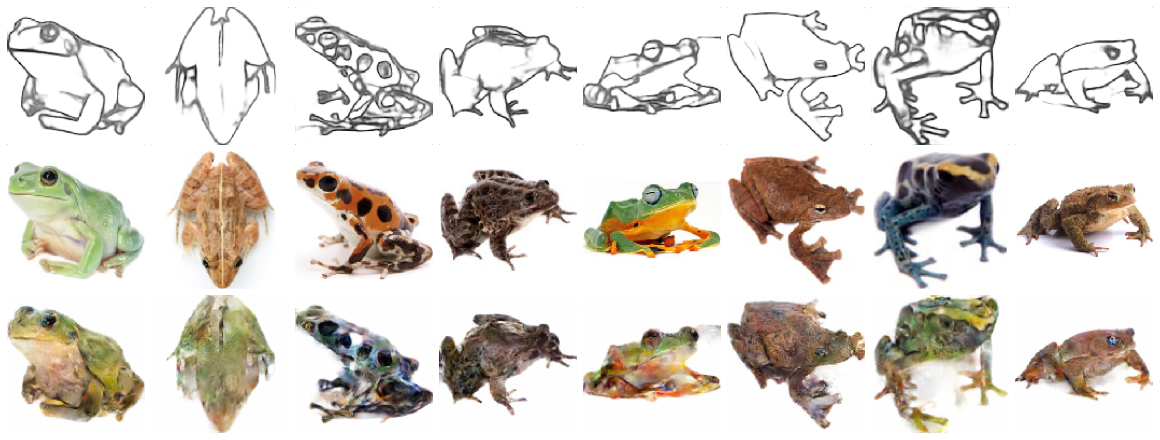

In [7]:
img_num = 0
to_plot = 8

for x_batch, y_batch in valid_ds.take(1):
    preds = (model.generator(x_batch).numpy()+1)/2
    
    x_batch = x_batch.numpy()
    y_batch = (y_batch.numpy()+1)/2
    
    fig = plt.Figure(figsize=[16,6], constrained_layout=True)
    gs = fig.add_gridspec(3,to_plot)
    
    for i, imgs in enumerate(zip(x_batch, y_batch, preds)):
        for j, img in enumerate(imgs):
            ax = fig.add_subplot(gs[j,i])
            if j==0:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.axis('off')
        if i == to_plot-1:
            break
             
    fig.set_facecolor('white')
    
    display(fig)
    img_num += 1

# Exploring Results

## PatchGAN Outputs

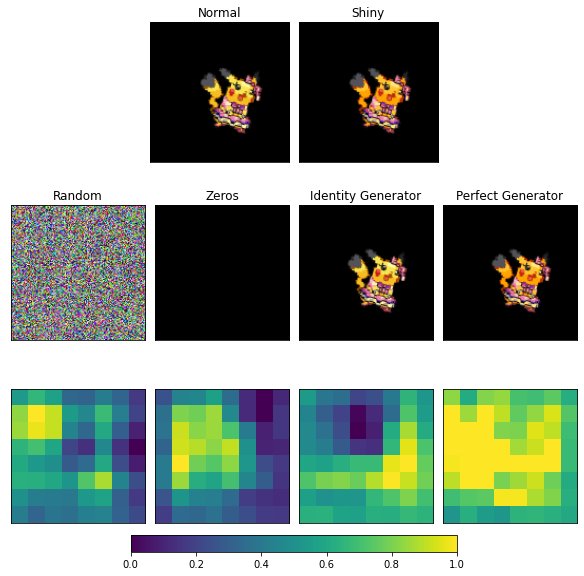

In [155]:
def plot_patches(normal, shiny):
    
    # Prepare the sub figures
    fig = plt.figure(constrained_layout=True, figsize=[8,8])
    gs0 = fig.add_gridspec(2,1, height_ratios=[1,2], hspace=0)

    gs00 = gs0[0].subgridspec(1,4)
    gs10 = gs0[1].subgridspec(2,4, hspace=0)

    # no ticks
    subplot_options = dict(xticks=[], yticks=[])

    # top 2
    ax1 = fig.add_subplot(gs00[1], title='Normal', **subplot_options)
    ax2 = fig.add_subplot(gs00[2], title='Shiny', **subplot_options)

    # Fake generator Ouputs
    ax3 = fig.add_subplot(gs10[0,0], title='Random', **subplot_options)
    ax4 = fig.add_subplot(gs10[0,1], title='Zeros', **subplot_options)
    ax5 = fig.add_subplot(gs10[0,2], title='Identity Generator', **subplot_options)
    ax6 = fig.add_subplot(gs10[0,3], title='Perfect Generator', **subplot_options)
    
    # PatchGan outputs
    ax7 = fig.add_subplot(gs10[1,0], **subplot_options)
    ax8 = fig.add_subplot(gs10[1,1], **subplot_options)
    ax9 = fig.add_subplot(gs10[1,2], **subplot_options)
    ax10 = fig.add_subplot(gs10[1,3], **subplot_options)
    
    # plot the images
    ax1.imshow((normal[0].numpy()+1)/2)
    ax2.imshow((shiny[0].numpy()+1)/2)
    
    # create random image
    rand_img = tf.random.uniform(normal.shape, -1, 1)
    rand_patch = model.discriminator([normal, rand_img])
    ax3.imshow((rand_img[0].numpy()+1)/2)
    ax7.imshow((rand_patch[0].numpy()+1)/2)
    
    # create random image
    zeros_img = -tf.ones_like(normal)
    zeros_patch = model.discriminator([normal, zeros_img])
    ax4.imshow((zeros_img[0].numpy()+1)/2)
    ax8.imshow((zeros_patch[0].numpy()+1)/2)
    
    # Identity generator
    ident_patch = model.discriminator([normal, normal])
    ax5.imshow((normal[0].numpy()+1)/2)
    ax9.imshow((ident_patch[0].numpy()+1)/2)
    
    # Perfect generator
    perfect_patch = model.discriminator([normal, shiny])
    ax6.imshow((shiny[0].numpy()+1)/2)
    im = ax10.imshow((perfect_patch[0].numpy()+1)/2, vmin=0, vmax=1)

    # styling
    cb = fig.colorbar(im, ax=[ax7,ax8,ax9,ax10], anchor=(0.5,0.5), orientation='horizontal', fraction=.1)
    cb.boundaries = [0,1]
    fig.set_facecolor('white')

    plt.show()
    plt.close()
    
# for x_batch, y_batch in train_ds.take(1):
#     plot_patches(x_batch[:1], y_batch[:1])

## Bulk examples

In [1]:
# make a directory to save the results
VIZ_PATH = PATH / 'visualisations' / RUN_NAME / '100E'
if not os.path.exists(VIZ_PATH):
    os.makedirs(VIZ_PATH)

# make predictions on many validation images and save the results to a folder
img_num = 0
to_plot = 8

for x_batch, y_batch in valid_ds.take(25):
    preds = (model.generator(x_batch).numpy()+1)/2
    
    x_batch = x_batch.numpy()
    y_batch = (y_batch.numpy()+1)/2
    
    fig = plt.Figure(figsize=[16,6], constrained_layout=True)
    gs = fig.add_gridspec(3,to_plot)
    
    for i, imgs in enumerate(zip(x_batch, y_batch, preds)):
        for j, img in enumerate(imgs):
            ax = fig.add_subplot(gs[j,i])
            if j==0:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.axis('off')
        if i == to_plot-1:
            break
             
    fig.set_facecolor('white')
    
    fig.savefig(f'visualisations/{RUN_NAME}/100E/{img_num}')
    display(fig)
    img_num += 1

In [37]:
wandb.finish()

_runtime,10913
_timestamp,1630017837
_step,298
epoch,98
d_loss_real,0.01008
d_loss_fake,0.17072
gen_total_loss,17.80082
gen_gan_loss,7.61216
gen_l1_loss,0.10189


_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
d_loss_real,█▄▂▃▄▄▃▃▂▂▄▃▃▂▂▁▃▁▂▂▆▁▂▁▁▃▁▁▁▁▁▁▁▁▁▆▂▁▁▁
d_loss_fake,▄▃▂▂▃▃▂▃▃▃▃▂▃▂▂▂▄▂▂▁▃▂▂▂▂▃▁▁▁▁▂▁▁▁▁█▁▁▁▂
gen_total_loss,▇▄▆▄▆▂▃▁▂▂▁▁▂▂▁▄▃▂▂▄▃▄▄▂▄▄▂▃▁▃▄▄▃▄▅█▄▃▄▆
gen_gan_loss,▁▁▂▂▁▁▁▁▁▁▁▁▂▂▂▃▄▃▃▄▄▄▄▃▄▅▃▄▃▃▅▄▄▃▅█▄▃▄▆
gen_l1_loss,█▅▇▄▇▃▄▂▃▃▂▂▃▂▁▃▂▂▂▃▁▂▃▁▃▂▁▂▁▂▂▂▂▃▃▃▂▂▃▂
